![header](./figures/logos_partenaires._cmems_se.jpg)

# Quickstart SWOT error calibration

<div style="text-align: right"><i> 2022-09-19 QUICKSTART </i></div>

***
**Authors:**  Datlas, IMT Atlantique & IGE <br>
**Copyright:** 2022 Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
    <h1><center>Quickstart</center></h1>
    <h5>Context: The row SWOT data will be contaminated by errors (Gauthier et al., 2016 ; Peral and Esteban-Fernandez, 2018). 
    In order to be able to observe front, mesoscale and sub-mesoscale features the SWOT data will require specific processing. 
    Also, these errors are expected to strongly pollute the derivatives of the SSH data which are used for the computation of geostrophic currents. Hence, being able to remove the SWOT errors are of significant importance to recover information on 2D surface currents and vertical mixing.</h5> 
</div> 


In [1]:
import os
import glob
import sys
import numpy as np
sys.path.append('..')
from src.swot import *
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info" role="alert">

<h2>0. Download input files </h2>

</div>

In [2]:
# Check if inputs have already been downloaded otherwise do
if len(os.listdir('inputs'))<2:
    # Get pseuso-observation
    print('Downloading and unzipping inputs')
    !wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/2022c_SWOT_error_calibration_GS/dc_SWOTcalibGS_inputs.tar.gz
    !tar -xvf dc_SWOTcalibGS_inputs.tar.gz dc_SWOTcalibGS_inputs    
    !mv dc_SWOTcalibGS_inputs  inputs/    
    !rm dc_SWOTcalibGS_inputs.tar.gz 

<div class="alert alert-info" role="alert">

<h2>1. Read input files
<h4> - "ssh_err" the input variable
<h4> - "ssh_true" the target variable
<h4> Only the third SWOT pass is filtered as an illustration</div>


In [3]:
list_of_file_inputs = sorted(glob.glob('inputs/dc_SWOTcalibGS_inputs/dc_SWOTcalibGS_input_pass*.nc')) 

# Only the third SWOT pass for quickstart example
swt_input = SwotTrack(list_of_file_inputs[3])
swt_input._dset

<xarray.Dataset>
Dimensions:    (time: 553, nC: 61)
Coordinates:
  * time       (time) datetime64[ns] 2012-10-27T07:19:48.946086 ... 2012-10-2...
  * nC         (nC) int64 0 1 2 3 4 5 6 7 8 9 ... 51 52 53 54 55 56 57 58 59 60
Data variables:
    lat        (time, nC) float64 ...
    lon        (time, nC) float64 ...
    lat_nadir  (time) float32 ...
    lon_nadir  (time) float32 ...
    x_ac       (time, nC) float64 ...
    x_al       (time) float32 ...
    ssh_true   (time, nC) float64 ...
    ssh_err    (time, nC) float64 ...
Attributes: (12/26)
    Conventions:               CF-1.6
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    corresponding_grid:        /data/MSA_ETU/mballarotta/ETUDE_BOOST-SWOT/out...
    creator_email:             lucile.gaultier@gmail.com
    creator_name:              Lucile Gaultier and Clement Ubelmann
    date_created:              2018-11-27T12:56:51Z
    ...                        ...
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...
    standard_name_vocabulary:  CF-1.6
    summary:                   SWOT grid data produced
    time_coverage_end:         0.03536939882970834
    time_coverage_start:       0.00035300925925696447
    title:                     SWOT-like data simulated by SWOT simulator

<div class="alert alert-info" role="alert">

<h2>2. Compute geostrophic velocities from simulated true SSH and from noisy SSH </h2>

</div>

The geostrophic currents calculation is:
$$
u_g(x,y) = - \frac{g}{f(x,y)}\frac{\partial h(x,y)}{\partial y}
$$
$$
v_g(x,y) = \frac{g}{f(x,y)}\frac{\partial h(x,y)}{\partial x}
$$
$$
\vec{U_g} = u_g.\vec{x} + v_g.\vec{y} 
$$

with:

$ f(x,y) = 2 \Omega sin(latitude(x,y))$ ,the Coriolis frequency

$\vec{x}$ and $\vec{y}$ define the local frame of reference in the swath

*Note: For simplification, we considered here:* 
- a 3-points stencil width, the first derivatives discretisation schemes, such as:

$$
\frac{\partial h(x,y)}{\partial y} = \frac{ h(i, j+1) - h(i, j-1) } {2 dy}, 
$$

- the beta plane approximation for the derivation of the geostrophic current near the Equator is not implemented 

In [5]:
swt_input.compute_geos_current('ssh_err', 'geos_current_err')
swt_input.compute_geos_current('ssh_true', 'geos_current_true')

<div class="alert alert-info" role="alert">

<h2>3. Compute relative vorticity from simulated true geostrophic velocities and from simulated noisy geostrophic velocities </h2>

</div>

The relative vorticity (normalized by $f$) is derived from the geostrophic current field:

$$
\zeta_f = \frac{1}{f} (\frac{\partial v_g}{\partial x} - \frac{\partial u_g}{\partial y})
$$

a 3-points stencil width is also considered for these derivative

In [6]:
swt_input.compute_relative_vorticity('geos_current_true_x', 'geos_current_true_y', 'ksi_true')
swt_input.compute_relative_vorticity('geos_current_err_x', 'geos_current_err_y', 'ksi_err')

<div class="alert alert-info" role="alert">

<h2>4. Example of INPUT field: Simulated SWOT noisy Sea surface Height data and derived geostrophic current </h2>
<h5> The input SSH field is here polluted by random noise (Left Figure) as precribed by the SWOTsimulator. This noise pollution has a strong impact on the first derivative of the SSH field: the geostrophic currents </h5>
    
</div>

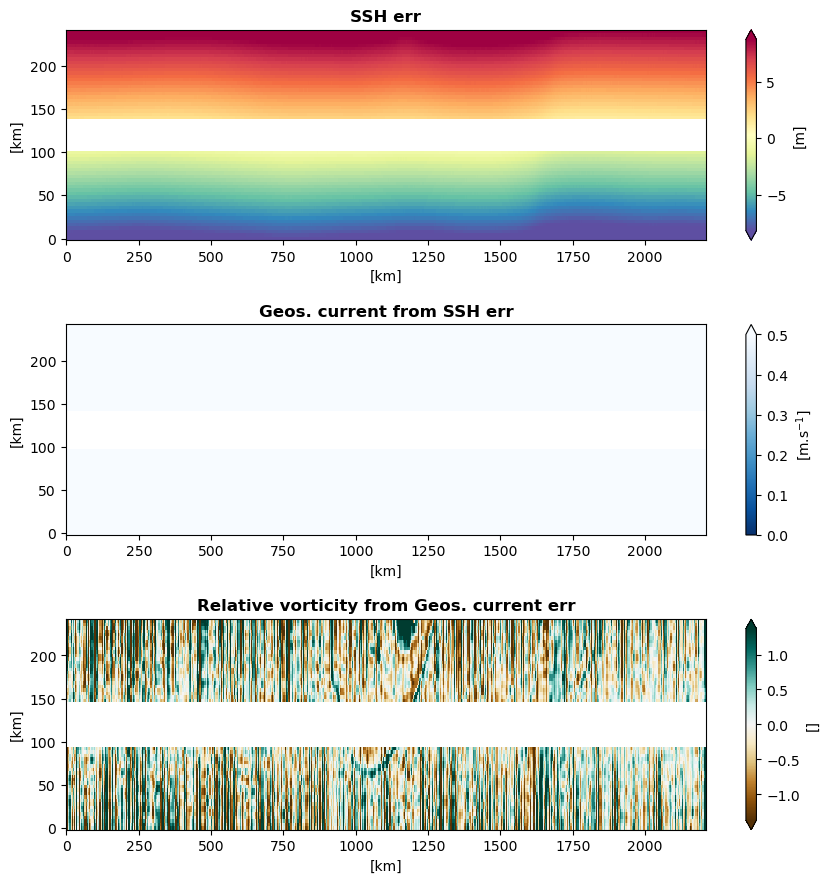

In [8]:
mask, vmin, vmax = swt_input.display_demo('err')

<div class="alert alert-info" role="alert">

<h2>5. Example of TARGET field to reconstruct: Simulated True SWOT Sea surface Height data and derived geostrophic current </h2>

</div>

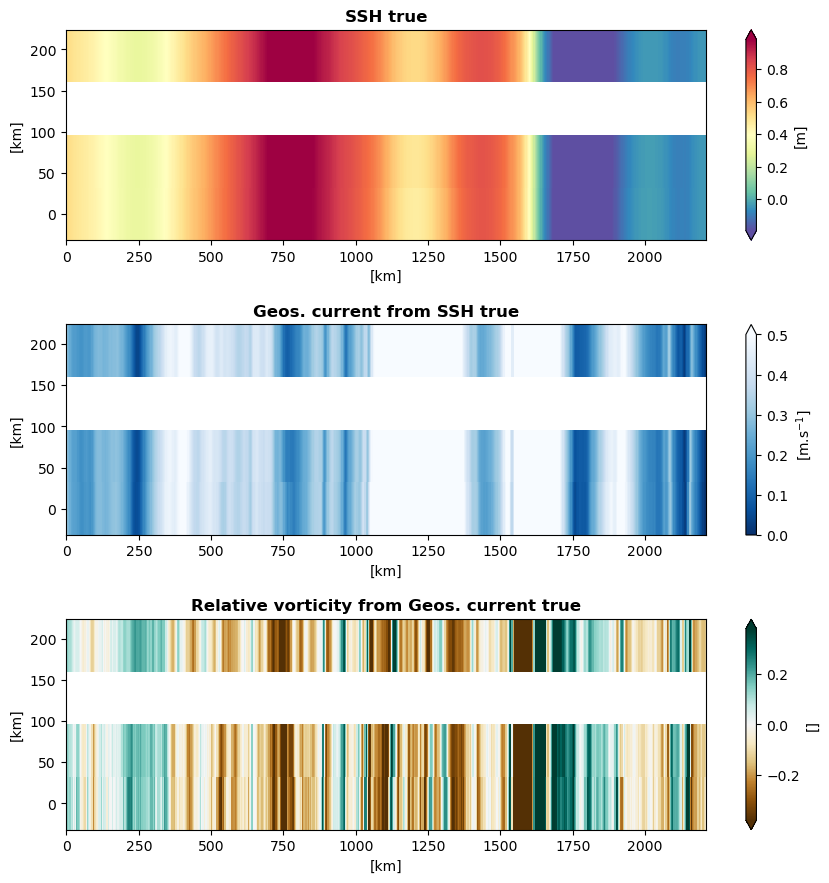

In [12]:
tmp_msk, tmp_v0, tmp_v1 = swt_input.display_demo('true', mask)

<div class="alert alert-info" role="alert">

<h2>6. Apply the baseline calibration </h2>

</div>

In [13]:
filename = list_of_file_inputs[3]
swt = SwotTrack(filename)  
swt.apply_ac_track_slope_calib('ssh_err', 'ssh_err_calib')

<div class="alert alert-info" role="alert">

<h2>7. Compute geostrophic current from this calibrated SSH </h2>

</div>

In [17]:
swt.compute_geos_current('ssh_err_calib', 'geos_current_err_calib')
swt.compute_relative_vorticity('geos_current_err_calib_x', 'geos_current_err_calib_y', 'ksi_err_calib')

<div class="alert alert-info" role="alert">

<h2>8. Display performance of baseline </h2>

</div>

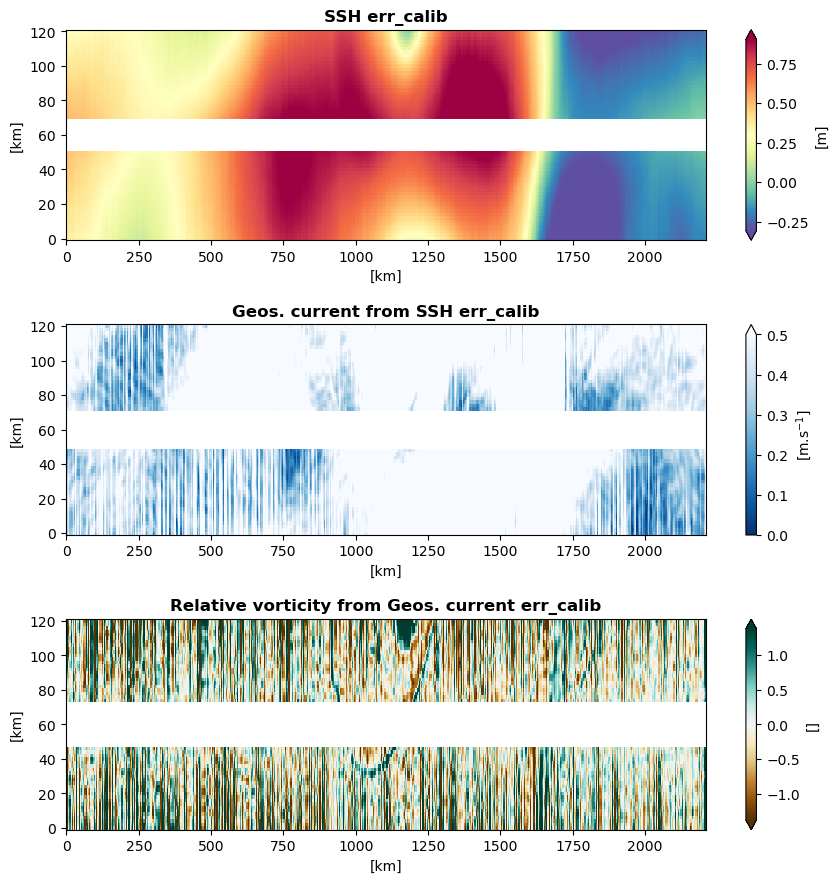

In [19]:
tmp_msk, tmp_v0, tmp_v1 = swt.display_demo('err_calib')

<div class="alert alert-info" role="alert">

<h2>9. Baseline calibration improvement </h2>

</div>

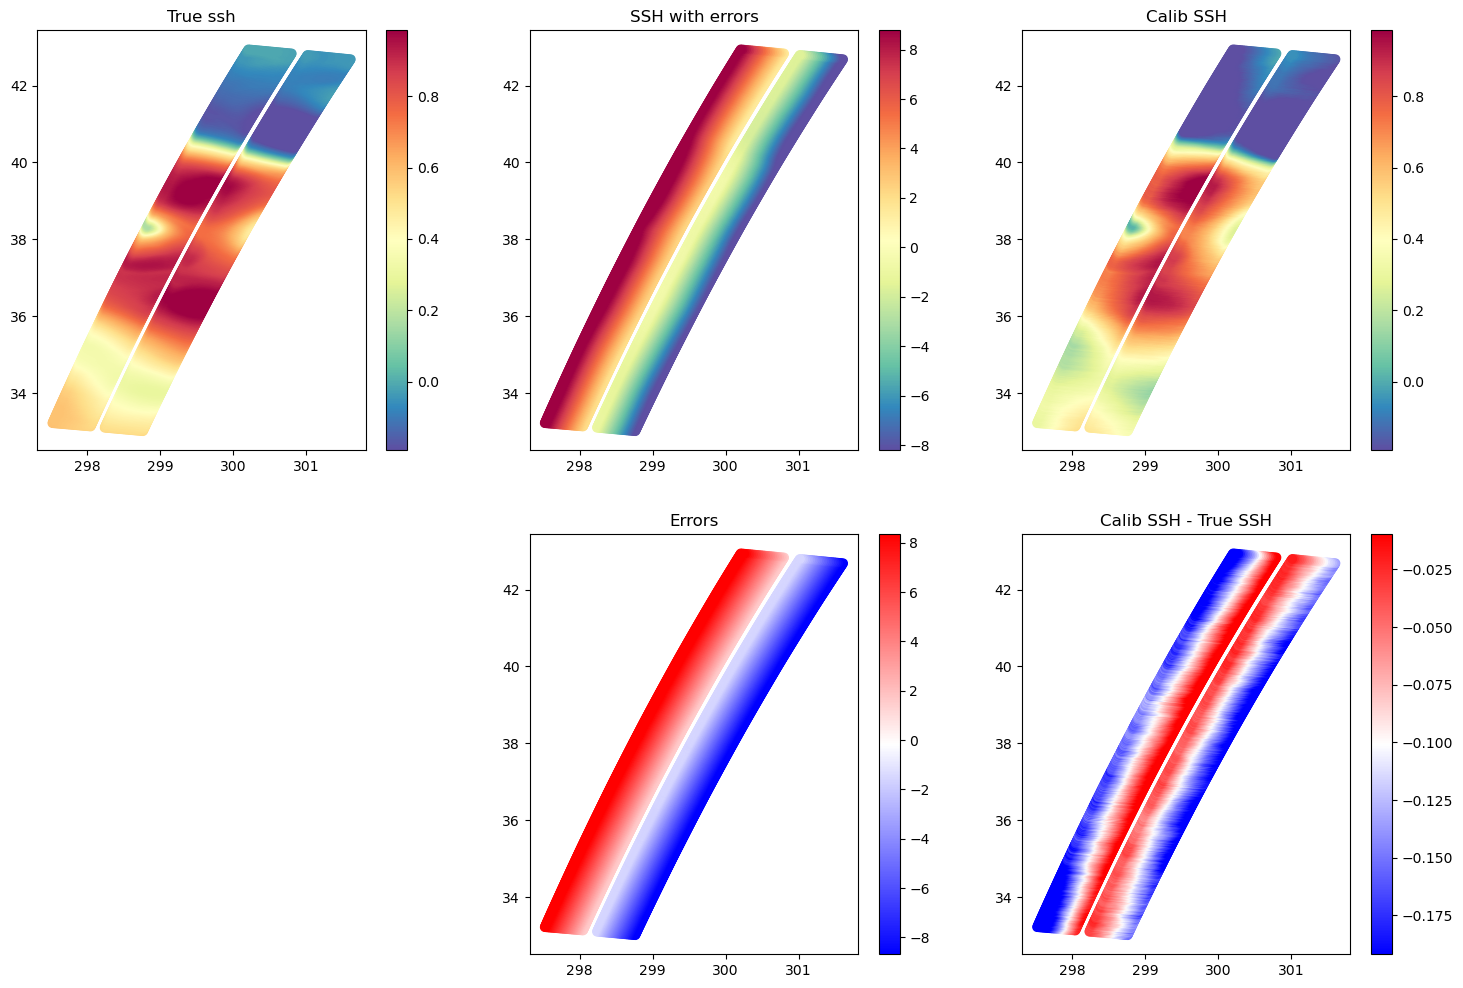

In [27]:
swt.plot_track('ssh_err_calib',swt)

In [28]:
RMSEerr = np.sqrt(np.mean((swt._dset.ssh_true-swt._dset.ssh_err)**2))

print('RMSEerr =',RMSEerr.values)

RMSEcalib = np.sqrt(np.mean((swt._dset.ssh_true-swt._dset.ssh_err_calib)**2))

print('RMSEcalib =',RMSEcalib.values)

RMSEerr = 5.794705214635958
RMSEcalib = 0.11536965662281372


<div class="alert alert-info" role="alert">

<h2>10. Save filtered output </h2>

</div>

In [31]:
output_var_names = ['ssh_err_calib', 'lon',  'lat']
output_file_path = './results/quickstart_baseline.nc' 
swt.to_netcdf(output_var_names, output_file_path)